In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
import os, sys

import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

import yaml
import scipy
import numpy as np
import pandas as pd

proj_root = os.path.dirname(os.path.dirname(os.path.abspath(".")))
sys.path.append(proj_root)

from minatar import Environment

from minatar_dqn.my_dqn import Conv_QNET, build_environment
from minatar_dqn.redo import apply_redo_parametrization

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set()

from experiments.experiment_utils import (
    seed_everything,
    search_files_containing_string,
    split_path_at_substring,
    collect_training_output_files,
)

For each checkpoint of an experiment we want to prune with different pruning factors and compare against different thresholds + redo scores

In [5]:
# Collect all paths to models in a specified folder
file_dir = os.path.dirname(os.path.abspath("."))
training_outputs_folder_path = os.path.join(proj_root, "experiments", "training", "outputs")
pruning_outputs_folder_path = os.path.join(file_dir, "outputs")
training_timestamp_folder = "2023_05_22-08_44_19"

experiments_folder = os.path.join(training_outputs_folder_path, training_timestamp_folder)

experiment_paths = collect_training_output_files(
        os.path.join(training_outputs_folder_path, training_timestamp_folder)
    )

for exp in experiment_paths:
    exp["models_folder_path"] = os.path.dirname(exp["model_path"])


In [7]:
experiment_paths[0]

{'model_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\model_checkpoints\\mck_25',
 'training_folder_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0',
 'config_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\conv16_lin64_asterix_0_config',
 'stats_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\conv16_lin64_asterix_0_train_stats',
 'models_folder_path': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0\\model_checkpoints'}

In [24]:
with open(experiment_paths[0]["config_path"], "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

cfg

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.99,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 5000,
   'target_model_update_freq': 100,
   'train_step_cnt': 200000,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 125000}},
 'environment': 'asterix',
 'epochs_to_train': 25,
 'estimator': {'args_': {'conv_hidden_out_size': 16,
   'lin_hidden_out_size': 64},
  'model': 'Conv_QNET'},
 'experiment_name': 'conv16_lin64_asterix_0',
 'experiment_output_folder': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs\\2023_05_22-08_44_19\\conv16_lin64\\asterix\\0',
 'experiment_start_timestamp': '2023_05_22-08_44_19',
 'optim': {'args_': {'eps': 0.00015, 'lr': 6.25e-05}, 'name': 'Adam'},
 'path_experiments_outputs': 'd:\\Work\\PhD\\minatar_work\\experiments\\training\\outputs',
 'redo': {'beta': 0.1, 'enabled': True, 'tau': 

In [60]:
def compare_redo_pruning(exp_paths):

    training_stats_data = torch.load(exp_paths["stats_path"])
    redo_scores = training_stats_data["redo_scores"]["policy"]

    checkpoints_paths = search_files_containing_string(
        exp_paths["models_folder_path"], "mck", substring_location="containing"
    )

    # read the config so that the model architecture can be loaded
    with open(exp_paths["config_path"], "r") as ymlfile:
        cfg = yaml.safe_load(ymlfile)

    results = []
    for checkpoint_path in checkpoints_paths:
        
        # Build a new model
        validation_env = build_environment(
            cfg["environment"], cfg["seed"]
        )

        # returns state as [w, h, channels]
        state_shape = validation_env.observation_space.shape

        # permute to get batch, channel, w, h shape
        # specific to minatar
        in_features = (state_shape[2], state_shape[0], state_shape[1])
        in_channels = in_features[0]
        num_actions = validation_env.action_space.n

        checkpoint_model = Conv_QNET(in_features = in_features, 
                                    in_channels = in_channels, 
                                    num_actions = num_actions, 
                                    **cfg["estimator"]["args_"])
        checkpoint_model = apply_redo_parametrization(checkpoint_model, tau=0.1)

        # Get the state of the model
        checkpoint_models_state = torch.load(checkpoint_path)
        checkpoint_model.load_state_dict(checkpoint_models_state["policy_model_state_dict"])
        model_state = checkpoint_model.state_dict()

        # Compute kendall rank correlation coefficient for each layer
        layer_weight_keys = ["features.0.weight", "features.2.weight", "fc.0.weight"]
        for i, layer_key in enumerate(layer_weight_keys):
            weights = model_state[layer_key]

            # compute the weight of the neurons in this layer
            if weights.dim() > 2:
                l1_norms = torch.sum(torch.abs(weights), dim=(1, 2, 3))
            else:
                l1_norms = torch.sum(torch.abs(weights), dim=(1))

            neuron_rankings = torch.argsort(l1_norms)

            check_index = int(os.path.basename(checkpoint_path).split("_")[1]) - 1 # get the index of the checkpoint
            
            redo_score = redo_scores[check_index][i]
            redo_rankings = torch.argsort(redo_score)

            # Calculate the Kendall rank correlation coefficient
            # k_corr, k_pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)
            k_corr, k_pval = scipy.stats.kendalltau(neuron_rankings, redo_rankings)


            # Calculate the Spearman rank correlation coefficient
            # s_corr, s_pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)
            s_corr, s_pval = scipy.stats.spearmanr(neuron_rankings, redo_rankings)

            p_corr, p_pval = scipy.stats.pearsonr(l1_norms, redo_score)


            new_row = {"seed": cfg["seed"],
                       "env": cfg["environment"],
                       "experiment": "_".join(cfg["experiment_name"].split("_")[:-2]),
                        "checkpoint": os.path.basename(checkpoint_path),
                        "epoch": check_index, 
                        "layer": layer_key,
                        "kendall_r_corr": k_corr, 
                        "kendall_r_pval": k_pval,
                        "spearman_r_corr": s_corr, 
                        "spearman_r_pval": s_pval,
                        "pearson_corr": p_corr, 
                        "pearson_pval": p_pval
                        }
            results.append(new_row)

    df = pd.DataFrame(results)

    return df 
    

In [66]:
exp_analysis_results = []

for exp_paths in experiment_paths:
    exp_analysis_results.append(compare_redo_pruning(exp_paths))


# concatenate the dataframes vertically
df_res = pd.concat(exp_analysis_results)
df_res

c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment MinAtar/Asterix-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\reg

,seed,env,experiment,checkpoint,epoch,layer,kendall_r_corr,kendall_r_pval,spearman_r_corr,spearman_r_pval,pearson_corr,pearson_pval
0,0,asterix,conv16_lin64,mck_1,0,features.0.weight,0.083333,0.690095,0.082353,0.761733,0.473772,6.376420e-02
1,0,asterix,conv16_lin64,mck_1,0,features.2.weight,0.650000,0.000215,0.835294,0.000056,0.286141,2.826493e-01
2,0,asterix,conv16_lin64,mck_1,0,fc.0.weight,-0.094246,0.270989,-0.117628,0.354603,0.942497,3.299078e-31
3,0,asterix,conv16_lin64,mck_10,9,features.0.weight,-0.083333,0.690095,-0.100000,0.712516,0.228346,3.949844e-01
4,0,asterix,conv16_lin64,mck_10,9,features.2.weight,0.066667,0.756555,0.029412,0.913896,-0.465026,6.952611e-02
...,...,...,...,...,...,...,...,...,...,...,...,...
70,1,space_invaders,conv8_lin32_space,mck_8,7,features.2.weight,0.357143,0.275099,0.523810,0.182721,0.863247,5.755883e-03
71,1,space_invaders,conv8_lin32_space,mck_8,7,fc.0.weight,0.129032,0.309633,0.190982,0.295075,0.554283,9.958119e-04
72,1,space_invaders,conv8_lin32_space,mck_9,8,features.0.weight,0.214286,0.548413,0.357143,0.385121,0.751124,3.170254e-02
73,1,space_invaders,conv8_lin32_space,mck_9,8,features.2.weight,-0.642857,0.031151,-0.833333,0.010176,0.575495,1.355253e-01


In [101]:
# big TODO
# Experiment 1: Set a threshold -> computed to select nr of dead neurons
# Compute pruning indexes. Compute huffman distance or simillar
# Do this as we advance through training

# Experiment 2: set a threshold
# Find the dead neurons and compute l1 norm of neurons
# plot the l1 norms through training

19

In [ ]:
# use tau = 1 for finding dead neurons
# histogram of the l1 norm of dead neurons during training

In [73]:
# metric_col = 'pearson_corr'
# metric_col = 'spearman_r_corr'
metric_col = 'kendall_r_corr'

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_4868\3525010963.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_df = df_res.groupby(['env', 'experiment', 'epoch']).mean().reset_index()


Text(0.5, 0.98, 'kendall_r_corr')

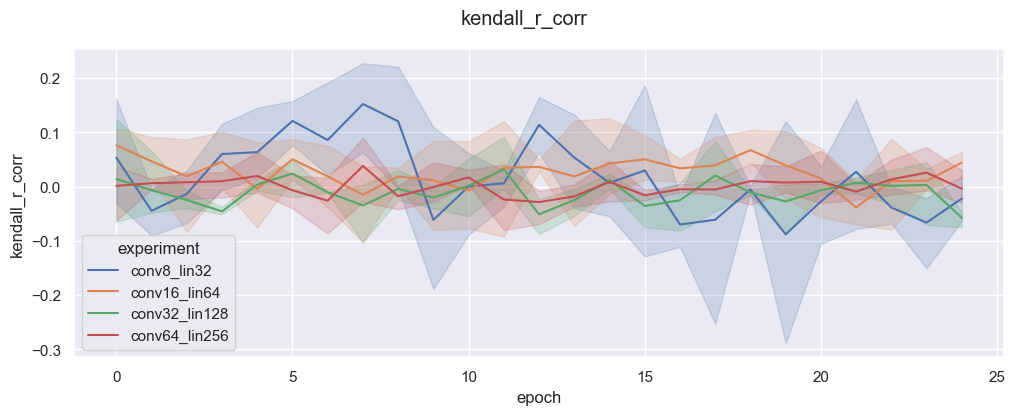

In [74]:
experiment_order = ['conv8_lin32', 'conv16_lin64', 'conv32_lin128', 'conv64_lin256']

# Compute the average metric between the seeds for each experiment
avg_df = df_res.groupby(['env', 'experiment', 'epoch']).mean().reset_index()

fig, ax = plt.subplots(figsize=(12, 4))

sns.lineplot(avg_df, x="epoch", y=metric_col, hue='experiment', hue_order = experiment_order, ax = ax)

fig.suptitle(metric_col)

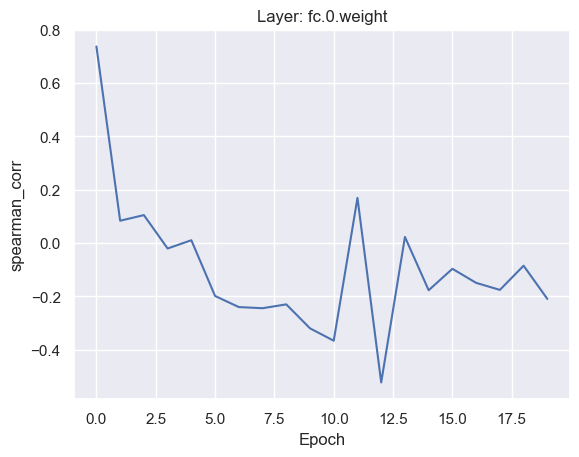

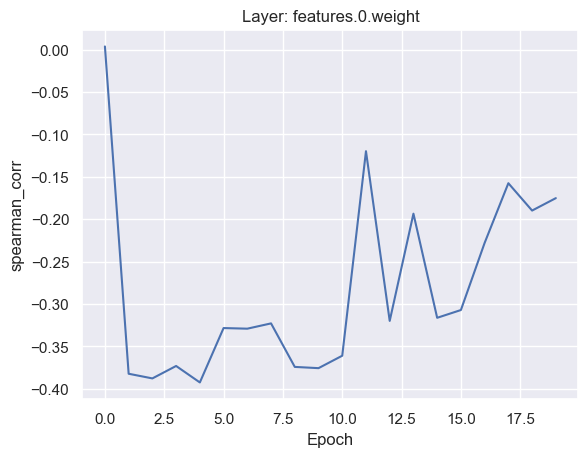

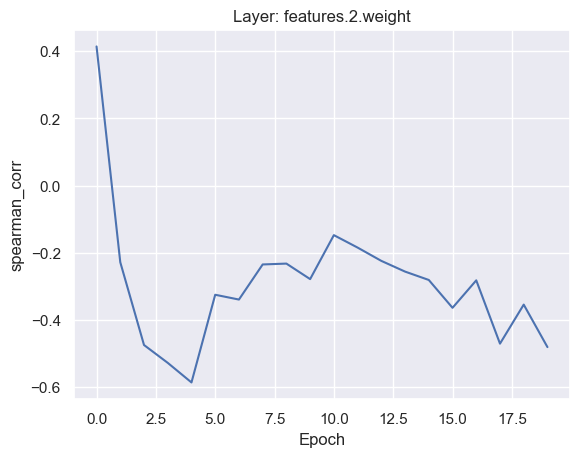

In [97]:
results_df = compare_redo_pruning(experiment_paths[1])

# Group the DataFrame by layer
grouped_df = results_df.groupby('layer')

# Iterate over each layer and create scatter plots
for layer, data in grouped_df:
    plt.figure()
    plt.plot(data['epoch'], data[corr_col])  
    plt.title(f'Layer: {layer}')
    plt.xlabel('Epoch')
    plt.ylabel(corr_col)
    plt.show()

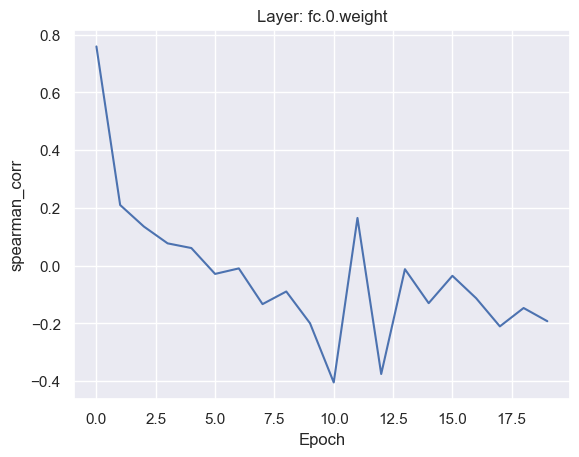

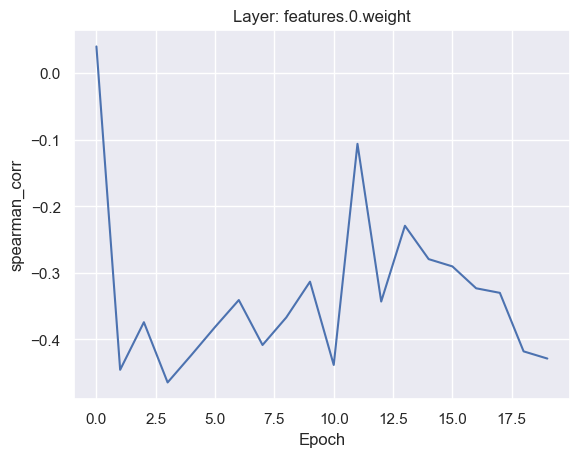

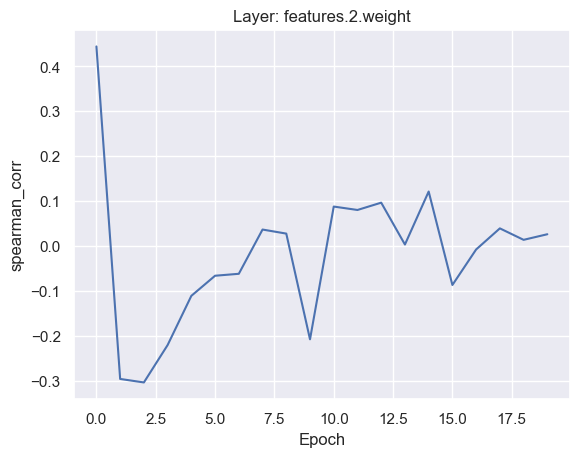

In [98]:
results_df = compare_redo_pruning(experiment_paths[2])

# Group the DataFrame by layer
grouped_df = results_df.groupby('layer')

# Iterate over each layer and create scatter plots
for layer, data in grouped_df:
    plt.figure()
    plt.plot(data['epoch'], data[corr_col])  
    plt.title(f'Layer: {layer}')
    plt.xlabel('Epoch')
    plt.ylabel(corr_col)
    plt.show()

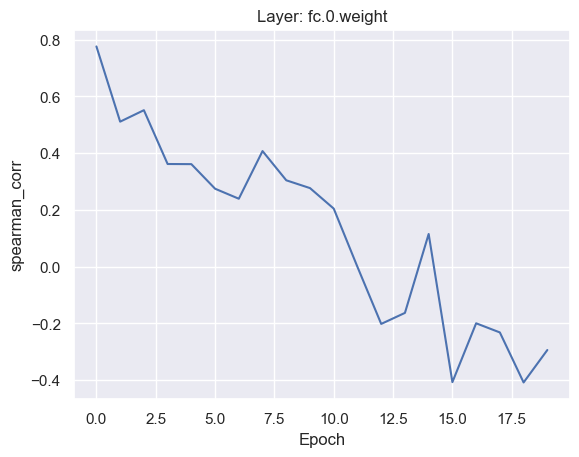

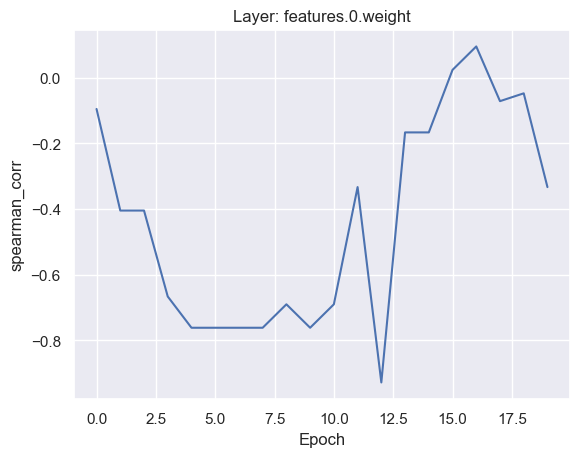

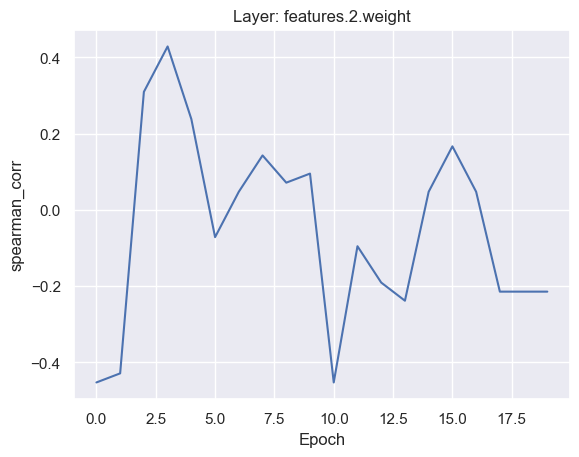

In [99]:
results_df = compare_redo_pruning(experiment_paths[3])

# Group the DataFrame by layer
grouped_df = results_df.groupby('layer')

# Iterate over each layer and create scatter plots
for layer, data in grouped_df:
    plt.figure()
    plt.plot(data['epoch'], data[corr_col])  
    plt.title(f'Layer: {layer}')
    plt.xlabel('Epoch')
    plt.ylabel(corr_col)
    plt.show()

In [31]:
t = torch.tensor([[0, 1, 3], [-1, 1, 0]])
torch.sum(torch.abs(t), dim=(1))

tensor([4, 2])

In [92]:
rank1 = torch.tensor([1, 2, 3, 4, 5])
rank2 = torch.tensor([1, 2, 3, 4, 5])

corr, pvalue = scipy.stats.kendalltau(rank1, rank2)
print("Kendall's rank correlation coefficient: ", corr)

correlation, p_value = scipy.stats.spearmanr(rank1, rank2)
print("Spearman's rank correlation coefficient:", correlation)

Kendall's rank correlation coefficient:  0.9999999999999999
Spearman's rank correlation coefficient: 0.9999999999999999


In [93]:
rank1 = torch.tensor([1, 2, 3, 4, 5])
rank2 = torch.tensor([2, 3, 1, 4, 5])

corr, pvalue = scipy.stats.kendalltau(rank1, rank2)
print("Kendall's rank correlation coefficient: ", corr)

correlation, p_value = scipy.stats.spearmanr(rank1, rank2)
print("Spearman's rank correlation coefficient:", correlation)

Kendall's rank correlation coefficient:  0.6
Spearman's rank correlation coefficient: 0.7


In [39]:
rank1 = [1, 2, 3, 4, 5]
rank2 = [2, 1, 3, 5, 4] 

corr, pvalue = scipy.stats.kendalltau(rank1, rank2)
print("Kendall's rank correlation coefficient: ", corr)

correlation, p_value = scipy.stats.spearmanr(rank1, rank2)
print("Spearman's rank correlation coefficient:", correlation)

Kendall's rank correlation coefficient:  0.6
Spearman's rank correlation coefficient: 0.7999999999999999


In [36]:
rank1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rank2 = [1, 2, 3, 4, 5, 10, 9, 8, 7, 6] 

corr, pvalue = scipy.stats.kendalltau(rank1, rank2)
print("Kendall's rank correlation coefficient: ", corr)

correlation, p_value = scipy.stats.spearmanr(rank1, rank2)
print("Spearman's rank correlation coefficient:", correlation)

Kendall's rank correlation coefficient:  0.5555555555555555
Spearman's rank correlation coefficient: 0.7575757575757575


In [20]:
neuron_rankings

tensor([ 5, 40, 23, 58, 20, 51, 26, 57, 52, 41, 37, 54,  7, 42, 13, 53,  4, 14,
        15, 62, 18, 25, 30,  2, 34, 56, 43, 59, 35,  9,  1, 32, 28, 12, 38, 36,
        48,  0,  8, 21, 60, 17, 22, 24, 55, 29, 50,  3, 49,  6, 33, 45, 44, 16,
        27, 11, 39, 63, 10, 19, 61, 47, 46, 31])

In [68]:
redo_rankings

tensor([ 0, 48,  2, 54,  4,  5, 51,  7, 52, 53, 10, 42, 41, 13, 14, 15, 38, 37,
        57, 58, 20, 60, 62, 23, 40, 25, 26, 29, 30, 44, 16, 36, 61,  3, 50, 34,
        33, 21, 27, 31, 63, 28, 46, 49, 47, 39, 22, 17, 43,  6, 45, 19, 11, 18,
        56, 59, 35,  1, 24,  8,  9, 55, 32, 12])

In [51]:
pvalue

0.8943512599699821

In [ ]:
import pandas as pd

# Create an empty DataFrame with the desired column names
results_df = pd.DataFrame(columns=['experiment', 'accuracy'])

# Run experiments and append results to the DataFrame
for i in range(10):
    # Run experiment and get accuracy
    accuracy = run_experiment(i)

    # Append results to the DataFrame
    new_row = {'experiment': i, 'accuracy': accuracy}
    results_df = pd.concat([results_df, pd.DataFrame(new_row, index=[0])])

# Print the final results DataFrame
print(results_df)
